# <img style="float: left; padding-right: 10px; width: 200px" src="https://raw.githubusercontent.com/trivikverma/researchgroup/master/assets/media/logo.png"> EPA-122A *Spatial* Data Science 


## Lab 6: Clustering, spatial clustering, and geodemographics

**TU Delft**<br>
**Q2 2023**<br>
**Instructor:** Trivik Verma <br>
**[Centre for Urban Science & Policy]( https://cusp.tbm.tudelft.nl/)** <br>

---


## Table of Contents

* [Learning Goals](#chapter0)
* [Data](#chapter1)
    * [Getting to know the data](#section1_1)
* [An AirBnb geodemographic classification of Rio using K-means](#chapter2)
    * [Mapping the categories](#section2_1)
    * [Exploring th nature of the categories](#section2_2)
* [Regionalization algorithms](#chapter3)
    * [Defining space formally](#section3_1)
    * [Creating regions from areas](#section3_2)
    * [Mapping the resulting regions](#section3_3)
    * [Comparison with administrative Rio boroughs](#section3_4)
    * [A practice exercise for later (Optional)](#section3_5)

## Learning Goals <a class="anchor" id="chapter0"></a>


**What is statistical clustering?**

This session covers statistical clustering of spatial observations. Many questions and topics are complex phenomena that involve several dimensions and are hard to summarize into a single variable. In statistical terms, we call this family of problems *multivariate*, as oposed to *univariate* cases where only a single variable is considered in the analysis. Clustering tackles this kind of questions by reducing their dimensionality -the number of relevant variables the analyst needs to look at- and converting it into a more intuitive set of classes that even non-technical audiences can look at and make sense of. For this reason, it is widely used in applied contexts such as policymaking or marketing. In addition, since these methods do not require many preliminar assumptions about the structure of the data, it is a commonly used exploratory tool, as it can quickly give clues about the shape, form and content of a dataset.

The basic idea of statistical clustering is to summarize the information contained in several variables by creating a relatively small number of categories. Each observation in the dataset is then assigned to one, and only one, category depending on its values for the variables originally considered in the classification. If done correctly, the exercise reduces the complexity of a multi-dimensional problem while retaining all the meaningful information contained in the original dataset. This is because, once classified, the analyst only needs to look at in which category every observation falls into, instead of considering the multiple values associated with each of the variables and trying to figure out how to put them together in a coherent sense. When the clustering is performed on observations that represent areas, the technique is often called geodemographic analysis.

Although there exist many techniques to statistically group observations in a dataset, all of them are based on the premise of using a set of attributes to define classes or categories of observations that are similar *within* each of them, but differ *between* groups. How similarity within groups and dissimilarity between them is defined and how the classification algorithm is operationalized is what makes techniques differ and also what makes each of them particularly well suited for specific problems or types of data. As an illustration, we will only dip our toes into one of these methods, K-means, which is probably the most commonly used technique for statistical clustering.

In the case of analysing spatial data, there is a subset of methods that are of particular interest for many common cases in Geographic Data Science. These are the so-called *regionalization* techniques. Regionalization methods can take also many forms and faces but, at their core, they all involve statistical clustering of observations with the additional constraint that observations need to be geographical neighbors to be in the same category. Because of this, rather than category, we will use the term *area* for each observation and *region* for each category, hence regionalization, the construction of regions from smaller areas.

In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
from pysal.lib import weights
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster

## Data <a class="anchor" id="chapter1"></a>

The dataset we will use in this occasion is an extract from the online website [AirBnb](https://www.airbnb.com). AirBnb is a company that provides a meeting point for people looking for an alternative to a hotel when they visit a city, and locals who want to rent (part of) their house to make some extra money. The website has a continuously updated listing of all the available properties in a given city that customers can check and book through. In addition, the website also provides a feedback mechanism by which both ends, hosts and guests, can rate their experience. Aggregating ratings from guests about the properties where they have stayed, AirBnb provides additional information for every property, such as an overall cleanliness score or an index of how good the host is at communicating with the guests.

The original data are provided at the property level and for the entire Rio. However, since the total number of properties is very large for the purposes of this notebook, they have been aggregated at the Middle Super Output Area (MSOA), a geographical unit created by the Office of National Statistics of the UK. Although the original source contains information for the Rio, the vast majority of properties are located in Inner Rio, so the data we will use is restricted to that extent. Even in this case, not every polygon has at least one property. To avoid cases of missing values, the final dataset only contains those MSOAs with at least one property, so there can be average ratings associated with them.

Our goal in this notebook is to create a classification of areas (MSOAs) in central Rio based on the ratings of the AirBnb locations. This will allow us to create a typology for the geography of AirBnb in Rio and, to the extent the AirBnb locations can say something about the areas where they are located, the classification will help us understand the geography of residential Rio a bit better. One general caveat about the conclusions we can draw from an analysis like this one that derives from the nature of AirBnb data. On the one hand, this dataset is a good example of the kind of analyses that the data revolution is making possible as, only a few years ago, it would have been very hard to obtain a similarly large survey of properties with ratings like this one. On the other hand, it is important to keep in mind the kinds of biases that these data are subject to and thus the limitations in terms of generalizing findings to the general population. (Reflection) Consider here, how communities that do not have data available, may not infact be capable of data richness. In other words, a poor community cannot afford to sublet their houses on AirBnb. So how will data be produced for them? Do we disregard them when we conduct an analysis of how AirBnB impacts cities? (Back from my rant) At any rate, this dataset is a great example to learn about statistical clustering of spatial observations, both in a geodemographic as well as in a regionalization.

As usual, before anything, let us set the paths to where we have downloaded the data:

In [2]:
# This will be different on your computer and will depend on where
# you have downloaded the files
path = 'data/'

**IMPORTANT**: the paths above might have look different in your computer. 

Note that, in this case, the data are provided as two separate files, so you will have to create a folder (for the example above, named `airbnb`) and place both there.

The main bulk of data is stored in `rio_airbn_data.geojson`. Let us load it first!

We can read the local file if you have downloaded it:

In [3]:
# Read local GeoJSON file
abb = gpd.read_file(path+'rio_airbnb_data.geojson')

Learn more about [CRS](https://geopandas.org/projections.html).

In [4]:
# Manually set CRS (it might work without depending on 
# machine, but just in case)
abb.crs = ('epsg:27700')
abb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   neighbourhood             154 non-null    object  
 1   neighbourhood_group       0 non-null      float64 
 2   number_of_listings        154 non-null    int64   
 3   avg_rating                154 non-null    float64 
 4   avg_price                 154 non-null    float64 
 5   avg_reviews_per_month     154 non-null    float64 
 6   avg_no_of_reviews         154 non-null    float64 
 7   avg_days_of_availibility  154 non-null    float64 
 8   avg_no_of_bedrooms        154 non-null    float64 
 9   avg_no_of_beds            154 non-null    float64 
 10  avg_no_of_bathrooms       154 non-null    float64 
 11  avg_minimum_nights        154 non-null    float64 
 12  geometry                  154 non-null    geometry
dtypes: float64(10), geometry(1), int64(1), obj

Note that, in comparison to previous datasets, this one is provided in a new format, `.geojson`. GeoJSON files are a plain text file (you can open it on any text editor and see its contents) that follows the structure of the JSON format, widely used to exchange information over the web, adapted for geographic data, hence the `geo` at the front. GeoJSON files have gained much popularity with the rise of web mapping and are quickly becoming a de-facto standard for small datasets because they are readable by humans and by many different platforms. As you can see above, reading them in Python is exactly the same as reading a shapefile, for example.

Before we jump into exploring the data, one additional step that will come in handy down the line. Not every variable in the table is an attribute that we will want for the clustering. In particular, we are interested in review ratings, so we will only consider those. Hence, let us first manually write them so they are easier to subset:

In [5]:
ratings = ['number_of_listings','avg_rating', 'avg_price', 
           'avg_reviews_per_month', 'avg_no_of_reviews', 
           'avg_days_of_availibility', 'avg_no_of_bedrooms',
           'avg_no_of_beds', 'avg_no_of_bathrooms', 
           'avg_minimum_nights']

### Getting to know the data <a class="anchor" id="section1_1"></a>

The best way to start exploring the geography of AirBnb ratings is by plotting each of them into a different map. This will give us a univariate perspective on each of the variables we are interested in. Since we have many columns to plot, we will create a loop that generates each map for us and places it on a "subplot" of the main figure:

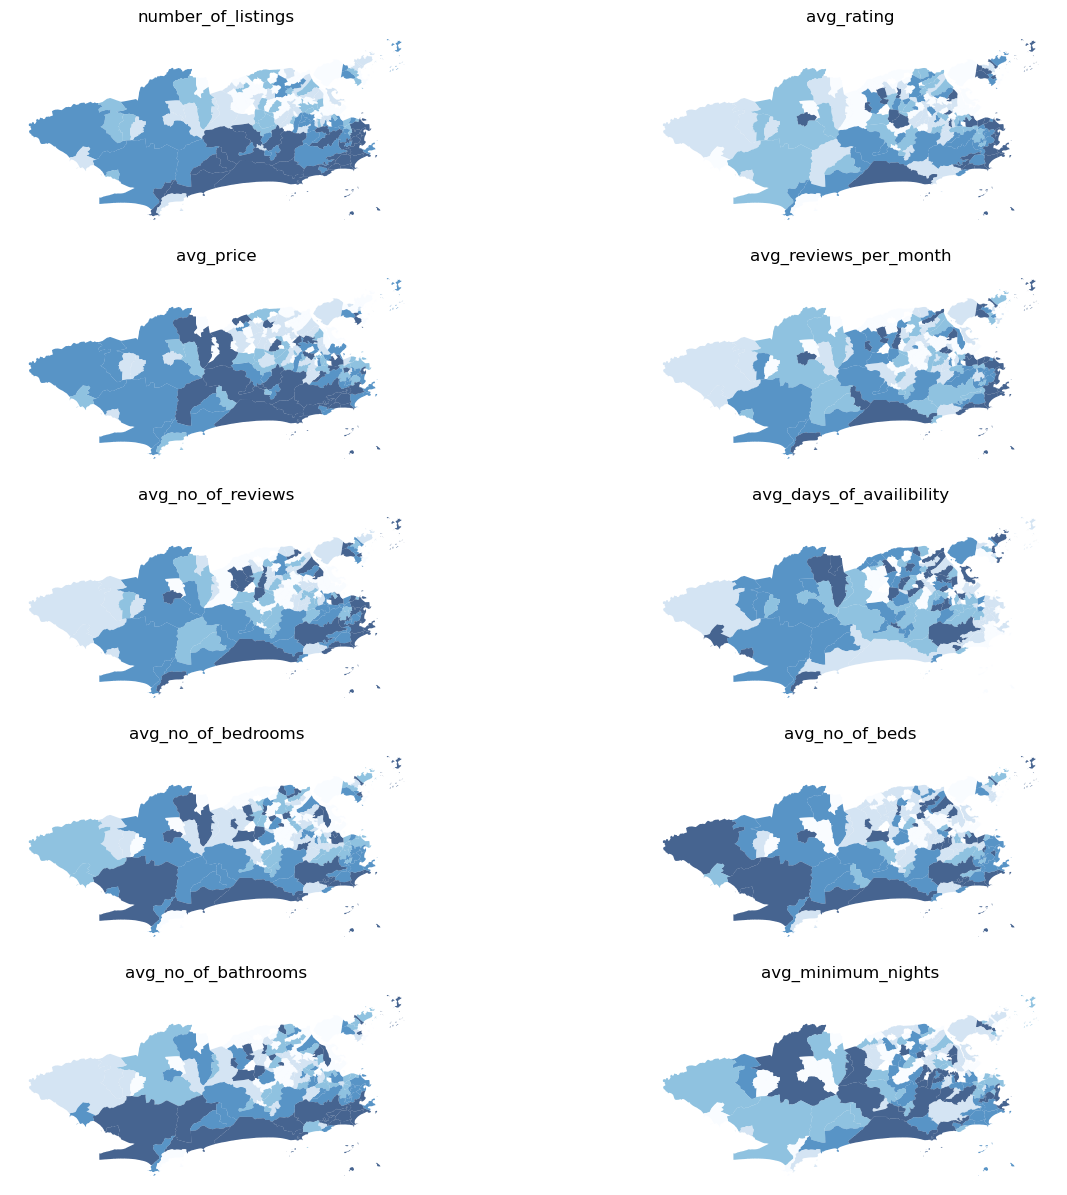

In [6]:
# Create figure and axes (this time it's 9, arranged 3 by 3) forgive the last 2 blank images
f, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(ratings):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    abb.plot(column=col, ax=ax, scheme='Quantiles', \
             linewidth=0, cmap='Blues', alpha=0.75)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

Before we delve into the substantive interpretation of the map, let us walk through the process of creating the figure above, which involves several subplots inside the same figure:

* First (Line 2) we set the number of rows and columns we want for the grid of subplots.
* Then we *unpack* the grid into a flat list (array) for the axes of each subplot that we can loop over (L. 4).
* At this point, we set up a `for` loop (L. 6) to plot a map in each of the subplots.
* Within the loop (L. 6-14), we extract the axis (L. 8), plot the choropleth on it (L. 10) and style the map (L. 11-14).
* Display the figure (L. 16).

As we can see, there is substantial variation in how the ratings for different aspects are distributed over space. While variables like the overall value (`review_scores_value`) or the communication (`review_scores_communication`) tend to higher in peripheral areas, others like the location score (`review_scores_location`) are heavily concentrated in the city centre.

Even though we only have seven variables, it is very hard to "mentally overlay" all of them to come up with an overall assessment of the nature of each part of Rio. For bivariate correlations, a useful tool is the correlation matrix plot, available in `seaborn`:

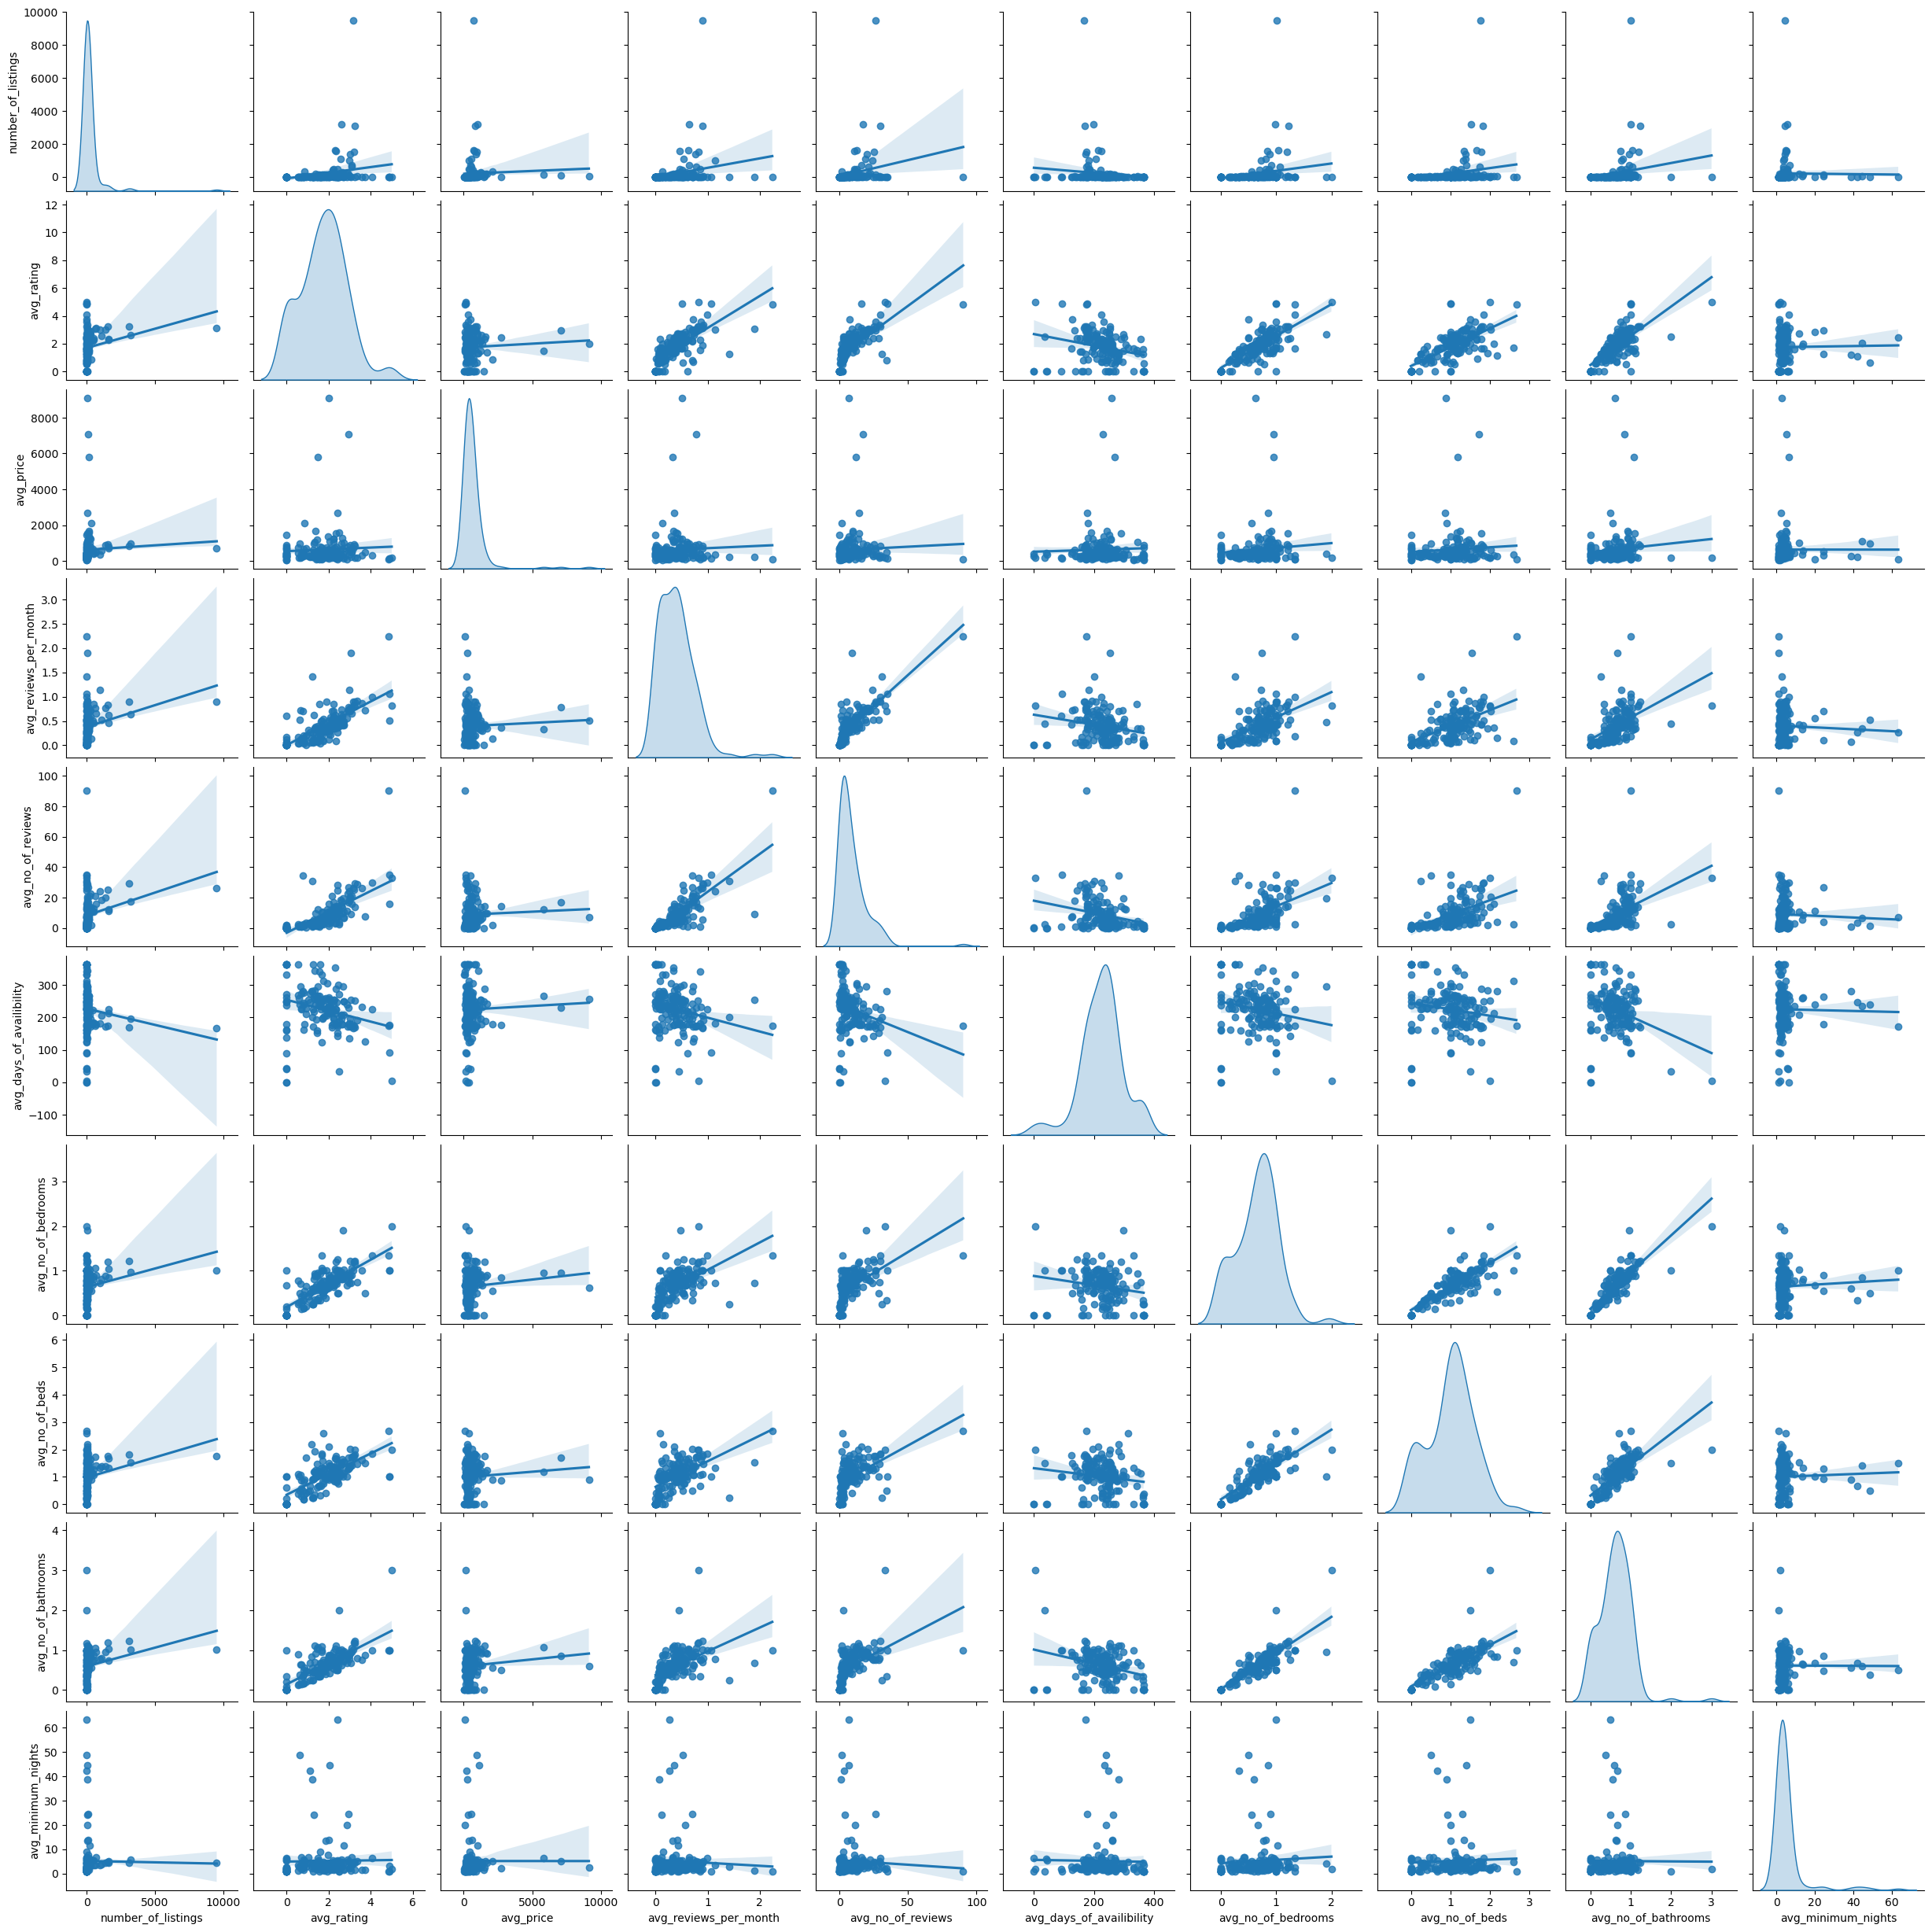

In [7]:
_ = sns.pairplot(abb[ratings], kind='reg', diag_kind='kde')

---

**Optional exercise**

Explore the help and the `seaborn` tutorial (find it on Google) for the function `pairplot` and experiment with some of the parameters. For example, recreate the figure above replacing the KDE plots with histograms.

---

This is helpful to consider uni and bivariate questions such as: *what is the relationship between the overall (`rating`) and location scores?* (Positive) *Are the overall ratings more correlated with location or with cleanliness?* (Cleanliness) However, sometimes, this is not enough and we are interested in more sophisticated questions that are truly multivariate and, in these cases, the figure above cannot help us. For example, it is not straightforward to answer questions like: *what are the main characteristics of the South of Rio?* *What areas are similar to the core of the city?* *Are the East and West of Rio similar in terms of the kind of AirBnb properties you can find in them?* For these kinds of multi-dimensional questions -involving multiple variables at the same time- we require a truly multidimensional method like statistical clustering.

## An AirBnb geodemographic classification of Inner Rio using K-means <a class="anchor" id="chapter2"></a>

A geodemographic analysis involves the classification of the areas that make up a greographical map into groups or categories of observations that are similar within each other but different between them. The classification is carried out using a statistical clustering algorithm that takes as input a set of attributes and returns the group ("labels" in the terminology) each observation belongs to. Depending on the particular algorithm employed, additional parameters, such as the desired number of clusters employed or more advanced tuning parameters (e.g. bandwith, radius, etc.), also need to be entered as inputs. For our geodemographic classification of AirBnb ratings in Inner Rio, we will use one of the most popular clustering algorithms: K-means. This technique only requires as input the observation attributes and the final number of groups that we want it to cluster the observations into. In our case, we will use five to begin with as this will allow us to have a closer look into each of them.

Although the underlying algorithm is not trivial, running K-means in Python is streamlined thanks to `scikit-learn`. Similar to the extensive set of available algorithms in the library, its computation is a matter of two lines of code. First, we need to specify the parameters in the `KMeans` method (which is part of `scikit-learn`'s `cluster` submodule). Note that, at this point, we do not even need to pass the data:

In [8]:
kmeans5 = cluster.KMeans(n_clusters=5)

This sets up an object that holds all the parameters required to run the algorithm. In our case, we only passed the number of clusters, but there are several other ones set by default:

In [9]:
kmeans5

KMeans(n_clusters=5)

To actually run the algorithm on the attributes, we need to call the `fit` method in `kmeans5`:

In [10]:
# This line is required to obtain the same results always. 
#(Computers are not truly random. They only seem that way. If this is interesting for you, ask me in class ;) Or try with a different seed.
np.random.seed(1234)
# Run the clustering algorithm
k5cls = kmeans5.fit(abb[ratings]) 

/Users/trivikverma/opt/anaconda3/envs/gds_osmnx/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The `k5cls` object we have just created contains several components that can be useful for an analysis. For now, we will use the labels, which represent the different categories in which we have grouped the data. Remember, in Python, life starts at zero, so the group labels go from zero to four. Labels can be  extracted as follows:

In [11]:
k5cls.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       4, 0, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 2, 1, 4, 1, 1, 4,
       1, 1, 3, 1, 3, 1, 3, 3, 3, 4, 4, 4, 3, 1, 4, 1, 0, 1, 1, 1, 1, 1],
      dtype=int32)

Each number represents a different category, so two observations with the same number belong to same group. The labels are returned in the same order as the input attributes were passed in, which means we can append them to the original table of data as an additional column:

In [12]:
abb['k5cls'] = k5cls.labels_

### Mapping the categories <a class="anchor" id="section2_1"></a>
 
To get a better understanding of the classification we have just performed, it is useful to display the categories created on a map. For this, we will use a unique values choropleth, which will automatically assign a different color to each category:

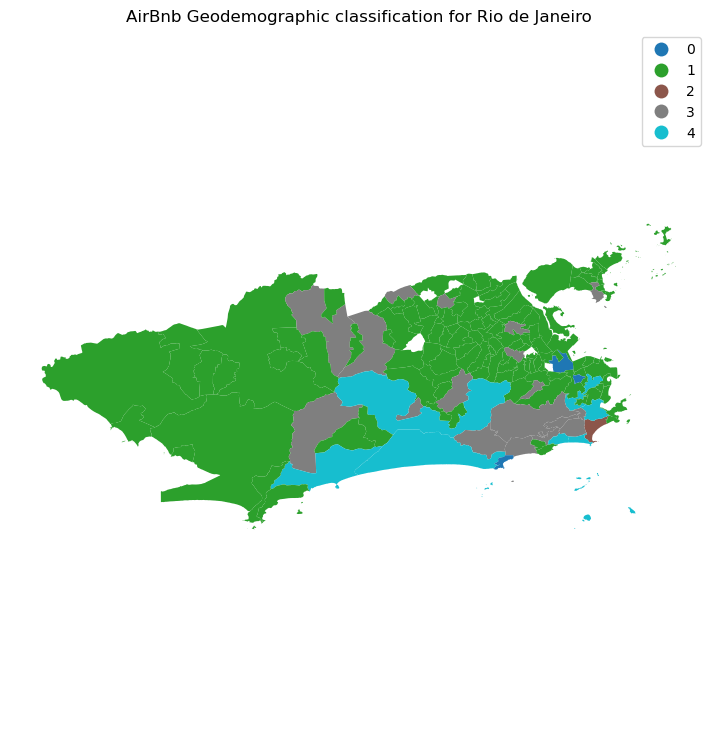

In [13]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('AirBnb Geodemographic classification for Rio de Janeiro')
# Display the map
plt.show()

The map above represents the geographical distribution of the five categories created by the K-means algorithm. A quick glance shows a strong spatial structure in the distribution of the colors: group three (brown) is mostly found in the city centre and barely in the periphery, while group two (orange) is the opposite. Group zero (red) is an intermediate one, while group three (brown) and one (green) are much smaller, containing only a small number of observations.

### Exploring the nature of the categories <a class="anchor" id="section2_2"></a>

Once we have a sense of where and how the categories are distributed over space, it is also useful to explore them statistically. This will allow us to characterize them, giving us an idea of the kind of observations subsumed into each of them. As a first step, let us find how many observations are in each category. To do that, we will make use of the `groupby` operator introduced before, combined with the function `size`, which returns the number of elements in a subgroup:

In [14]:
k5sizes = abb.groupby('k5cls').size()
k5sizes

k5cls
0      3
1    125
2      1
3     18
4      7
dtype: int64

The `groupby` operator groups a table (`DataFrame`) using the values in the column provided (`k5cls`) and passes them onto the function provided aftwerards, which in this case is `size`. Effectively, what this does is to groupby the observations by the categories created and count how many of them each contains. For a more visual representation of the output, a bar plot is a good alternative:

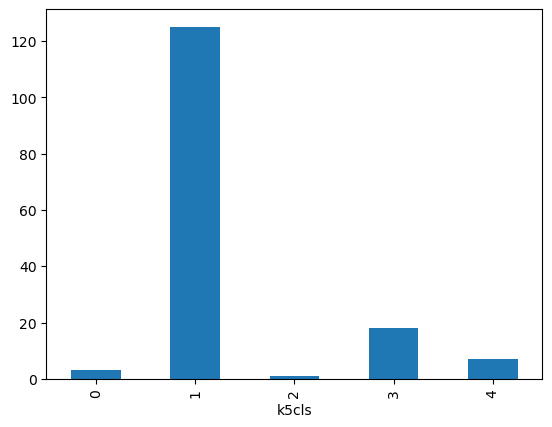

In [15]:
_ = k5sizes.plot.bar()

As we suspected from the map, groups varying sizes, with groups zero, three and four being over 75 observations each, and one and two being under twenty.

In order to describe the nature of each category, we can look at the values of each of the attributes we have used to create them in the first place. Remember we used the average ratings on many aspects (cleanliness, communication of the host, etc.) to create the classification, so we can begin by checking the average value of each. To do that in Python, we will rely again on the `groupby` operator but, in this case, we will combine it with the function `mean`:

In [16]:
# Calculate the mean by group
k5means = abb.groupby('k5cls')[ratings].mean()
# Show the table transposed (so it's not too wide)
k5means.T

k5cls,0,1,2,3,4
number_of_listings,90.000000,55.648000,9515.000000,100.888889,1915.285714
avg_rating,2.140074,1.690533,3.151107,1.680268,2.762089
avg_price,7338.041151,362.664698,725.293537,1357.675989,813.585185
avg_reviews_per_month,0.540368,0.381019,0.900337,0.361972,0.679204
avg_no_of_reviews,12.023698,8.370299,26.210510,7.346065,19.199475
avg_days_of_availibility,251.886577,224.956527,167.517288,237.584300,193.804177
avg_no_of_bedrooms,0.843669,0.614427,1.012507,0.733469,0.996949
avg_no_of_beds,1.262302,0.963723,1.761850,1.033662,1.555685
avg_no_of_bathrooms,0.845564,0.575224,1.005150,0.666548,0.991054
avg_minimum_nights,4.632994,4.713876,4.345349,8.570597,4.633591


Or we can try to get a more comprehensive description and include also the quartiles and the standard deviation by calling the function `describe` instead of simply `mean`:

In [17]:
# Calculate the summary by group
k5desc = abb.groupby('k5cls')[ratings].describe()
# Show the table
k5desc

number_of_listings                                                    \
                   count         mean         std     min      25%     50%   
k5cls                                                                        
0                    3.0    90.000000   37.986840    56.0    69.50    83.0   
1                  125.0    55.648000  141.334724     1.0     4.00     9.0   
2                    1.0  9515.000000         NaN  9515.0  9515.00  9515.0   
3                   18.0   100.888889  100.658356     1.0    14.75    64.0   
4                    7.0  1915.285714  850.515474  1090.0  1440.00  1569.0   

                      avg_rating            ... avg_no_of_bathrooms            \
          75%     max      count      mean  ...                 75%       max   
k5cls                                       ...                                 
0       107.0   131.0        3.0  2.140074  ...            0.964775  1.080153   
1        29.0   987.0      125.0  1.690533  ...            0.791667  3.000000   
2      9515.0  9515.0        1.0  3.151107  ...            1.005150  1.005150   
3       176.0   323.0       18.0  1.680268  ...            0.927484  1.102273   
4      2339.0  3190.0        7.0  2.762089  ...            1.107471  1.224984   

      avg_minimum_nights                                                     \
                   count      mean        std       min       25%       50%   
k5cls                                                                         
0                    3.0  4.632994   1.832122  2.625000  3.842620  5.060241   
1                  125.0  4.713876   7.966056  1.000000  1.750000  2.812500   
2                    1.0  4.345349        NaN  4.345349  4.345349  4.345349   
3                   18.0  8.570597  14.108582  1.000000  2.375812  3.572872   
4                    7.0  4.633591   0.662091  3.711927  4.300032  4.549375   

                            
            75%        max  
k5cls                       
0      5.636991   6.213740  
1      4.200000  63.500000  
2      4.345349   4.345349  
3      5.020362  48.875000  
4      4.907574   5.758621  

[5 rows x 80 columns]

However this approach quickly grows out of hand and the tables become very large to easily communicate any pattern. A good alternative is to visualize the distribution of values by category. The following shows how to transform the data so you can create a fairly sophisticated plot that summarizes the table above.


To do this conveniently, we need to "tidy up" the table of values. Recall the meaning of *tidy* in the context of data: a dataset is tidy if every row represents an individual observation and every column a single variable. The table we want to plot to replace the summary above contains the following data:

In [18]:
# Name (index) the rows after the category they belong
to_plot = abb.set_index('k5cls')
# Subset to keep only variables used in K-means clustering
to_plot = to_plot[ratings]
# Display top of the table
to_plot.head()

,number_of_listings,avg_rating,avg_price,avg_reviews_per_month,avg_no_of_reviews,avg_days_of_availibility,avg_no_of_bedrooms,avg_no_of_beds,avg_no_of_bathrooms,avg_minimum_nights
k5cls,,,,,,,,,,
1,47,3.034681,613.872340,0.699787,20.468085,196.085106,1.212766,2.021277,0.914894,2.595745
1,8,2.312500,199.250000,0.342500,2.875000,355.250000,0.750000,1.125000,0.625000,1.750000
1,6,3.261667,187.666667,0.805000,13.666667,252.000000,1.166667,2.000000,1.166667,1.666667
1,1,0.000000,230.000000,0.170000,2.000000,263.000000,0.000000,0.000000,0.000000,2.000000
1,32,3.365312,166.406250,0.916562,28.906250,192.437500,0.750000,1.468750,0.796875,5.125000


Following the definition of "tidy data", the table above does not quality as tidy: the names of the columns are a variable in itself, the type of rating that the value represents. If we want to tidy up the table, the column names need to be squeezed into a single column -type of rating. This operation, in `pandas` is called to "stack" a table, and can easily be accomplished as follows:

In [19]:
to_plot = to_plot.stack()
to_plot.head()

k5cls                       
1      number_of_listings        47.000000
       avg_rating                 3.034681
       avg_price                613.872340
       avg_reviews_per_month      0.699787
       avg_no_of_reviews         20.468085
dtype: float64

This returns a multi-indexed object, which we can convert it into a `DataFrame` by treating the index as additional columns:

In [20]:
to_plot = to_plot.reset_index()
to_plot.head()

,k5cls,level_1,0
0,1,number_of_listings,47.000000
1,1,avg_rating,3.034681
2,1,avg_price,613.872340
3,1,avg_reviews_per_month,0.699787
4,1,avg_no_of_reviews,20.468085


Finally, we can rename the columns to give them more meaningful names:

In [21]:
to_plot = to_plot.rename(columns={'level_1': 'Rating', 0: 'Values'})
to_plot.head()

,k5cls,Rating,Values
0,1,number_of_listings,47.000000
1,1,avg_rating,3.034681
2,1,avg_price,613.872340
3,1,avg_reviews_per_month,0.699787
4,1,avg_no_of_reviews,20.468085


At this point, we are ready to visualize the distribution of values by type of rating by category. This is done in two steps:

1. Set up of the axis ("facet") to plot by variable.
1. Building of the plot

Let us show the code first and we will explain it afterwards:

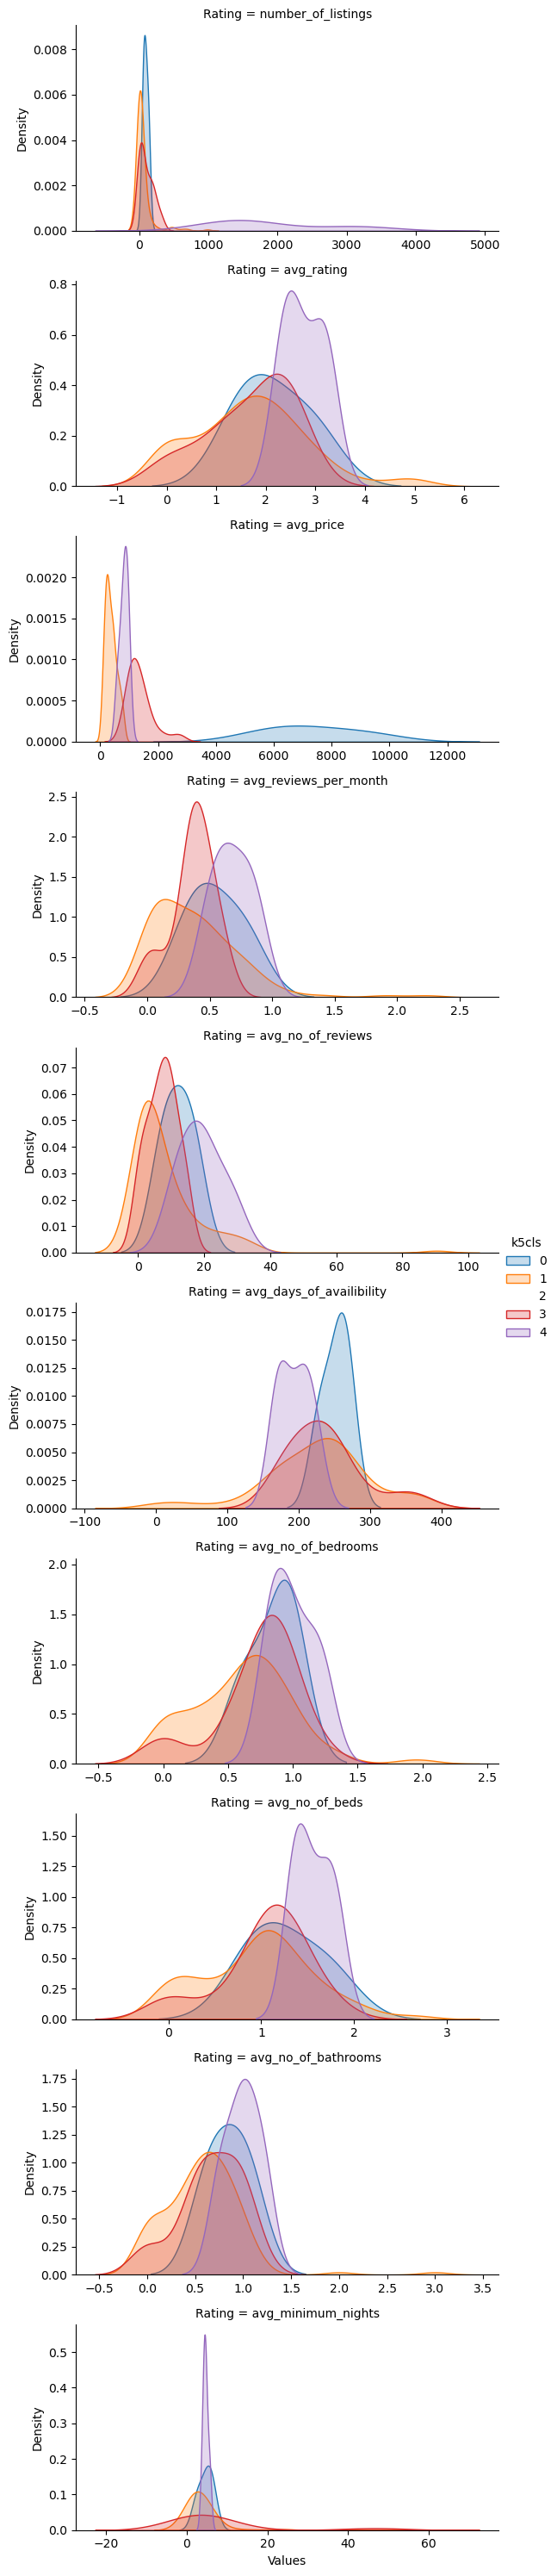

In [22]:
# Setup the facets
facets = sns.FacetGrid(data=to_plot, row='Rating', hue='k5cls', \
                  sharey=False, sharex=False, aspect=2)
# Build the plot as a `sns.kdeplot`
_ = facets.map(sns.kdeplot, 'Values', fill=True, warn_singular=False).add_legend()

Let us work through the logic of the lines of code above. First, the setup of facets (lines 2-3):

* What we are doing here is creating the "frames" onto which we will later plot. This part is crucial because here is where we specify the variables that we want to split the dataset into.
* We first pass the tidy dataset (`tidy`) to the argument `data`.
* Then we specify the argument `row` which controls how we will split the table `tidy` into plots that will take a different row each. In this case, we use the `Rating` column because we want a single plot for each type of rating (one for the overall rating, one for cleanliness, etc.).
* The next argument is `hue` which is another one to split the data into but, instead of defining differnt plots (as was the case for `row`), `hue` will split the data to create different elements in the same plot. In our case, this means that the split we specify here, by category (`k5cls`), will create different kernel densities within the same plot.
* The arguments `sharex` and `sharey`, which are set to `False`, imply that the scale of the horizontal and vertical axes respectively is not shared across plots. This makes different plots not directly comparable with each other, but generates graphs that make the best use of the available space, resulting in clearer visualizations.
* Finally, `aspect` controls the ratio of height and width of each plot. By setting it to 2, we create plots double long than high.

Once the "shell" of the figure is set up, the second part (line 5) provides the visual characteristics of each of the plots to be created. This is done by calling the function `map` on the `facets` object and specifying the following arguments:

* The first one is the function that we will use to plot the data. Because we want to visualize the distribution of values for each subgroup, we will use `sns.kdeplot`, which creates a kernel density estimation.
* The second one represents, on the data table specified before (`tidy` in our case), which values we want to plot. We pass the variable `Values`.
* Then is additional style arguments for `sns.kdeplot`. To color the area under the line, we set `shade` to `True`.
* Finally, we add an additional call, outside the `map` function to include a global legend with `add_legend`.

In substantive terms, the visualization shows the differences in each of the ratings by clustering group. Although in some cases, as in the checkin, these are not very large, others are more useful in stablishing differences across categories. For example, it singles out group one (green in the plots) as notably worse than the rest which, if we refer to the map we created above, corresponds with areas in green. Both the overall rating and the rating in terms of value (`review_scores_value`) establishes a hierarchy of categories by which the best is group four (grey areas in the map), then goes group zero (red in the map), followed by group three (brown areas in the map), and then group two (orange in the map). The visualization also makes clear that group one (green lines in the plots, green in the map) contains too little observations and too much noise to provide any meaningful information.

---

This concludes the section on geodemographics. As we have seen, the essence of this approach is to group areas based on a purely statistical basis: *where* each area is located is irrelevant for the label it receives from the clustering algorithm. In many contexts, this is not only permissible but even desirable, as the interest is to see if particular combinations of values are distributed over space in any discernible way. However, in other context, we may be interested in created groups of observations that follow certain spatial constraints. For that, we now turn into regionalization techniques.

---

**Optional exercise**

Create a new classification with 10 groups. Compare the output maps between the two solutions.

---

## Regionalization algorithms <a class="anchor" id="chapter3"></a>

Regionalization is the subset of clustering techniques that impose a spatial constraint on the classification. In other words, the result of a regionalization algorithm contains areas that are spatially contiguous. Efectively, what this means is that these techniques aggregate areas into a smaller set of larger ones, called regions. In this context then, areas are *nested* within regions. Real world examples of this phenomenon includes counties within states or, in the UK, local super output areas (LSOAs) into middle super output areas (MSOAs). The difference between those examples and the output of a regionalization algorithm is that while the former are aggregated based on administrative principles, the latter follows a statistical technique that, very much the same as in the standard statistical clustering, groups together areas that are similar on the basis of a set of attributes. Only that now, such statistical clustering is spatially constrained.

As in the non-spatial case, there are many different algorithms to perform regionalization, and they all differ on details relating to the way they measure (dis)similarity, the process to regionalize, etc. However, same as above too, they all share a few common aspects. In particular, they all take a set of input attributes *and* a representation of space in the form of a binary spatial weights matrix. Depending on the algorithm, they also require the desired number of output regions into which the areas are aggregated.

To illustrate these concepts, we will run a regionalization algorithm on the AirBnb data we have been using. In this case, the goal will be to re-delineate the boundary lines of the Inner Rio boroughs following a rationale based on the different average ratings on AirBnb proeperties, instead of the administrative reasons behind the existing boundary lines. In this way, the resulting regions will represent a consistent set of areas that are similar with each other in terms of the ratings received.

### Defining space formally <a class="anchor" id="section3_1"></a>

Very much in the same way as with ESDA techniques, regionalization methods require a formal representation of space that is statistics-friendly. In practice, this means that we will need to create a spatial weights matrix for the areas to be aggregated. 

Technically speaking, this is the same process as we have seen before, thanks to `PySAL`. The difference in this case is that we did not begin with a shapefile, but with a GeoJSON. Fortunately, `PySAL` supports the construction of spatial weights matrices "on-the-fly", that is from a table. This is a one-liner:

In [23]:
w = weights.Queen.from_dataframe(abb, use_index=False)

/Users/trivikverma/opt/anaconda3/envs/gds_osmnx/lib/python3.10/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 2 islands with ids: 0, 40.
  warnings.warn(message)


### Creating regions from areas <a class="anchor" id="section3_2"></a>

At this point, we have all the pieces needed to run a regionalization algorithm. For this example, we will use a spatially-constrained version of the agglomerative algorithm. This is a similar approach to that used above (the inner-workings of the algorithm are different however) with the difference that, in this case, observations can only be labelled in the same group if they are spatial neighbors, as defined by our spatial weights matrix `w`. The way to interact with the algorithm is very similar to that above. We first set the parameters:

In [24]:
sagg13 = cluster.AgglomerativeClustering(n_clusters=13, connectivity=w.sparse)
sagg13

AgglomerativeClustering(connectivity=<154x154 sparse matrix of type '<class 'numpy.float64'>'
	with 778 stored elements in Compressed Sparse Row format>,
                        n_clusters=13)

And we can run the algorithm by calling `fit`:

In [25]:
# This line is required to obtain the same results always
np.random.seed(1234)
# Run the clustering algorithm
sagg13cls = sagg13.fit(abb[ratings])

/Users/trivikverma/opt/anaconda3/envs/gds_osmnx/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:304: UserWarning: the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


And then we append the labels to the table:

In [26]:
abb['sagg13cls'] = sagg13cls.labels_

### Mapping the resulting regions <a class="anchor" id="section3_3"></a>

At this point, the column `sagg13cls` is no different than `k5cls`: a categorical variable that can be mapped into a unique values choropleth. In fact the following code snippett is exactly the same as before, only replacing the name of the variable to be mapped and the title:

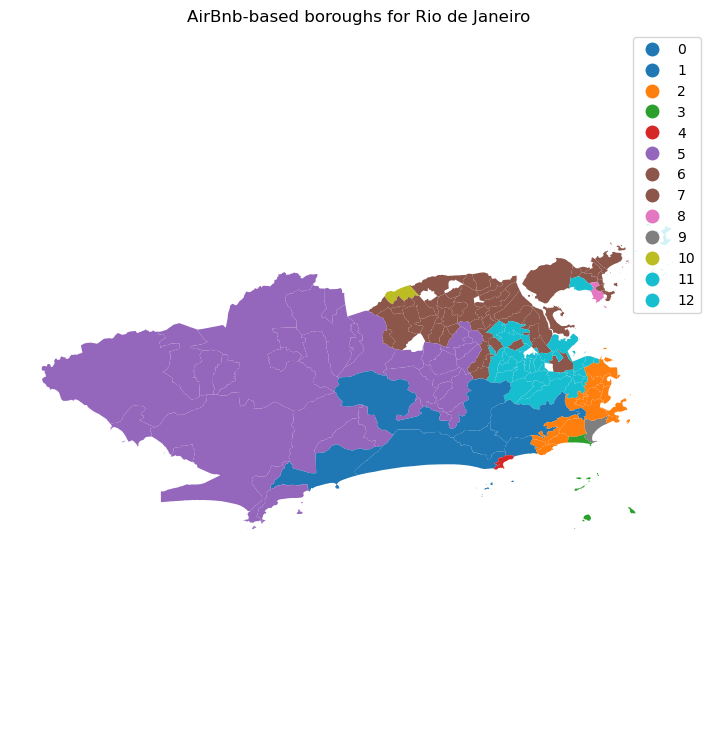

In [27]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(column='sagg13cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('AirBnb-based boroughs for Rio de Janeiro')
# Display the map
plt.show()



The map above gives a very clear impression of the boundary delineation of the algorithm. However, it is still based on the small area polygons. To create the new boroughs "properly", we need to dissolve all the polygons in each category into a single one. This is a standard GIS operation that is supported by `geopandas` and that can be easily actioned with the same `groupby` operator we used before. The only additional complication is that we need to wrap it into a separate function to be able to pass it on to `groupby`. We first the define the function `dissolve`:

In [28]:
def dissolve(gs):
    '''
    Take a series of polygons and dissolve them into a single one
    
    Arguments
    ---------
    gs        : GeoSeries
                Sequence of polygons to be dissolved
    Returns
    -------
    dissolved : Polygon
                Single polygon containing all the polygons in `gs`
    '''
    return gs.unary_union

The boundaries for the AirBnb boroughs can then be obtained as follows:

In [29]:
# Dissolve the polygons based on `sagg13cls`
abb_boroughs = gpd.GeoSeries(abb.groupby(abb['sagg13cls'])\
                                .apply(dissolve),
                             crs=abb.crs)

Which we can plot:

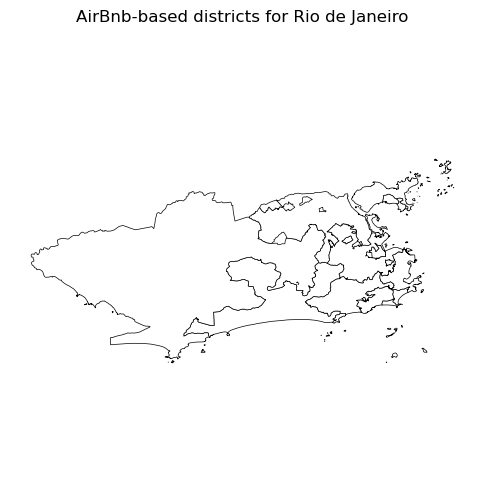

In [30]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
abb_boroughs.plot(ax=ax, linewidth=0.5,\
                  facecolor='white', edgecolor='k')
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('AirBnb-based districts for Rio de Janeiro')
# Display the map
plt.show()

---

### Comparison with the administrative Rio boroughs <a class="anchor" id="section3_4"></a>

The delineation we have just created can be compared with the administrative boundaries of the Inner Rio boroughs. These can be loaded up from the `geojson` file in the same way as we did with the original dataset.

We can read the file locally:

In [31]:
# Read GeoJSON file
admin_boroughs = gpd.read_file(path+'neighbourhoods.geojson')

In [32]:
# Manually set CRS (it might work without depending on 
# machine, but just in case)
admin_boroughs.crs = ('epsg:4326')
admin_boroughs.head()

,neighbourhood,neighbourhood_group,geometry
0,Paquetá,NaN,"MULTIPOLYGON Z (((-43.10567 -22.74888 0.00000,..."
1,Freguesia (Ilha),NaN,"MULTIPOLYGON Z (((-43.17170 -22.77661 0.00000,..."
2,Bancários,NaN,"MULTIPOLYGON Z (((-43.18915 -22.78318 0.00000,..."
3,Galeão,NaN,"MULTIPOLYGON Z (((-43.22804 -22.78374 0.00000,..."
4,Portuguesa,NaN,"MULTIPOLYGON Z (((-43.20763 -22.79498 0.00000,..."


The table above contains *all* the boroughs in Rio. Since our data is focused on Inner Rio, we need the list of boroughs considered part of Inner Rio to subset it. Let us manually input it for use later:

Subsetting the table is more easily done if we *index* the table on the names. Remember, by *indexing* we mean assigning one of the columns as the "name of the rows":

In [33]:
# Index on the name of the boroughs
admin_inner_boroughs = admin_boroughs.set_index('neighbourhood')
admin_inner_boroughs.head()

,neighbourhood_group,geometry
neighbourhood,,
Paquetá,NaN,"MULTIPOLYGON Z (((-43.10567 -22.74888 0.00000,..."
Freguesia (Ilha),NaN,"MULTIPOLYGON Z (((-43.17170 -22.77661 0.00000,..."
Bancários,NaN,"MULTIPOLYGON Z (((-43.18915 -22.78318 0.00000,..."
Galeão,NaN,"MULTIPOLYGON Z (((-43.22804 -22.78374 0.00000,..."
Portuguesa,NaN,"MULTIPOLYGON Z (((-43.20763 -22.79498 0.00000,..."


Onced indexed on names, we *reindex* it to the list of inner boroughs. Reindexing means replacing the original rows by those with the index that we are passing. In this case, it really means we are subsetting the table to keep only those in Inner Rio, but reindexing can do many more things:

Finally, one more piece of housekeeping. Since the original file is expressed in raw latitude and longitude, it is convenient to project it to the same CRS as we have been using:

In [34]:
# Projecting the dataset using the same CRS as the original abb table
admin_inner_boroughs = admin_inner_boroughs.to_crs(abb.crs)

And displayed in a similar way as with the newly created ones:

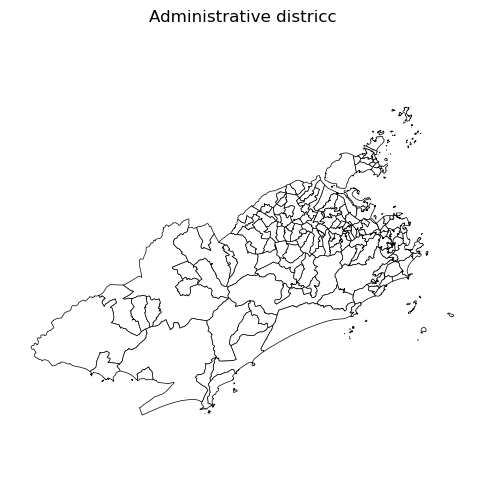

In [35]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
admin_inner_boroughs.plot(ax=ax, linewidth=0.5, \
                          edgecolor='k', facecolor='white')
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('Administrative districc')
# Display the map
plt.show()



In order to more easily compare the administrative and the "regionalized" boundary lines, we can plot them side by side. To do this, we need to create a figure that contains two subplots. The rest of the logic is fairly similar to the usual plotting approach:

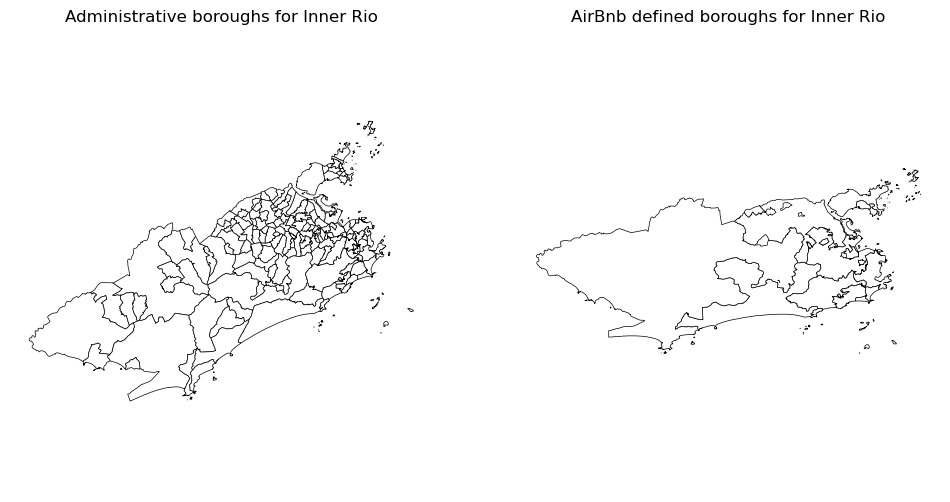

In [36]:
# Setup figure and an axis grid of one row and two columns
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Split the axs object (a list) into two
ax1 = axs[0]
ax2 = axs[1]
                    # First axis
# Plot boundary lines
admin_inner_boroughs.plot(ax=ax1, linewidth=0.5, \
                          edgecolor='k', facecolor='white')
# Remove axis
ax1.set_axis_off()
# Keep axes proportionate
ax1.axis('equal')
# Add title
ax1.set_title('Administrative boroughs for Inner Rio')
                    # Second axis
# Plot boundary lines
abb_boroughs.plot(ax=ax2, linewidth=0.5,\
                  facecolor='white', edgecolor='k')
# Remove axis
ax2.set_axis_off()
# Keep axes proportionate
ax2.axis('equal')
# Add title
ax2.set_title('AirBnb defined boroughs for Inner Rio')
# Display the map
plt.show()

The code to produce the figure above differs from the usual "single maps" in the following key aspects:

* When we set up the figure with `plt.subplots`, we create two subplots and, to align them horizontally, we specify the number of rows and columns separately.
* The resulting axes object, `axs` is not a single one but a sequence of them. Because of this, we can't plot directly on `axs`, but we need to access the axis objects explicitly, hence the two following lines (4 and 5).
* The plotting on each of the axes then proceeds in the same way as if it was a single one, as this is about what goes into each of the two axes. All you have to make sure is the plotting is being assigned into the right axis object (`ax1` or `ax2`).

---

Looking at the figure, there are several differences between the two maps. The clearest one is that, while the administrative boundaries have a very balanced size (with the exception of the city of Rio), the regions created with the spatial agglomerative algorithm are very different in terms of size between each other. This is a consequence of both the nature of the underlying data and the algorithm itself. Substantively, this shows how, based on AirBnb, we can observe large areas that are similar and hence are grouped into the same region, while there also exist pockets with characteristics different enough to be assigned into a different region.

---

### A practice exercise for later (Optional) <a class="anchor" id="section3_5"></a>

This exercise is for practice only. You can do it now, after your assignment, before the final project, or at another time in your degree. 

*Please refer to the lab on geo-visualisation to bring back memories of spatial data.*

Follow the steps below and conduct geodemographic analysis with clustering, spatial clustering.

- Select one area (urban area, city, county, state, etc. froma round the world) that you are interested in. Get a geojson data of that area, if it is hard to collect a geojson file, __get a shapefile and csv file to combine non-spatial tabular data with their spatial counter-part.__ (To jog your memory, please look at lab 3 and 4.)
- Explore the geography and data by plotting them into a map. 
- Perform k-means analysis with your data using `scikit-learn`, then plot the results into a map. The number of cluster doesn't have to be five. (Try to run several times to get an appropriate number of cluster, however, in this lab, you don't have to come up with 'optimised' number of cluster. Select any number that you feel reasonable depending on what you are exploring with your variables.)
- Conduct spatial weight analysis using `PySAL` and `AgglomerativeClustering`. Then plot the results. (Again, you don't have to choose 13 as the number of cluster, but try to explore several times and choose whatever you feel reasonable. The goal here is to get familiar with functions, not getting the best number for analysis.)
